<a href="https://colab.research.google.com/github/otakumesi/python-machine-learning-programming/blob/master/python_machine_learning_programming_part_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2019-03-06 11:38:18--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  11.6MB/s    in 0.8s    

2019-03-06 11:38:19 (11.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2019-03-06 11:38:20--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0.08s   

2019-03-06 11:38:21 (341 KB/s) - ‘train-labels-id

In [0]:
!gzip *ubyte.gz -d

In [0]:
!ls

sample_data		t10k-labels-idx1-ubyte	 train-labels-idx1-ubyte
t10k-images-idx3-ubyte	train-images-idx3-ubyte


In [0]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    labels_path = os.path.join(path,  '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,  '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
        
    return images,  labels

In [0]:
X_train, y_train = load_mnist('', kind='train')
print('Note: %d, columns: %d', (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('Note: %d, columns: %d', (X_test.shape[0], X_test.shape[1]))

Note: %d, columns: %d (60000, 784)
Note: %d, columns: %d (10000, 784)


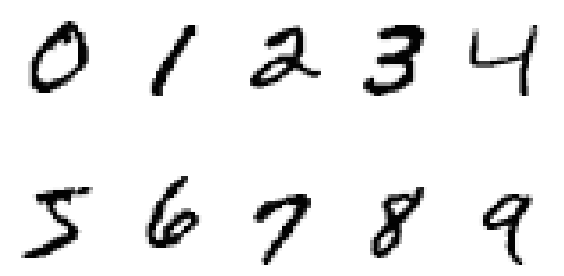

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

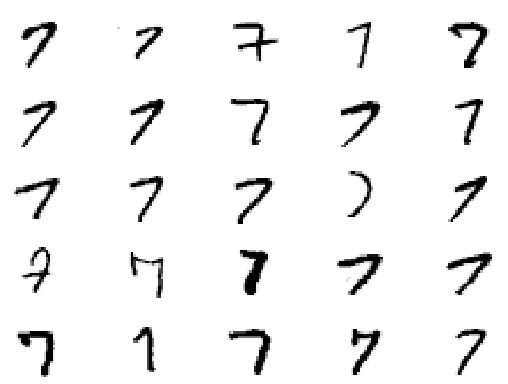

In [0]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [0]:
import numpy as np
np.savez_compressed('mnist_scaled.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [0]:
mnist = np.load('mnist_scaled.npz')

In [0]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [0]:
X_train = mnist['X_train']

In [0]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

In [0]:
import sys

class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2=0, epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1
        return onehot.T
    
    def _forward(self, X):
        z_h = X.dot(self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _compute_cost(self, y_enc, output):
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output + 1e-5))
        term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X):
        z_h, a_out, z_h, z_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                sigma_out = a_out - y_train_enc[batch_idx]
                
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_h = np.sum(sigma_out, axis=0)
                
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = np.sum(sigma_h, axis=0)
                self.w_h -= self.eta * delta_w_h 
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = np.sum(sigma_out, axis=0)
                self.w_out -= self.eta * delta_w_out 
                self.b_out -= self.eta * delta_b_out
                
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f | Train/Valid Acc.: %.2f%%/%.2f%% ' % (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

In [0]:
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=100, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)
nn.fit(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:])

100/100 | Cost: 7903.17 | Train/Valid Acc.: 98.47%/97.78% 

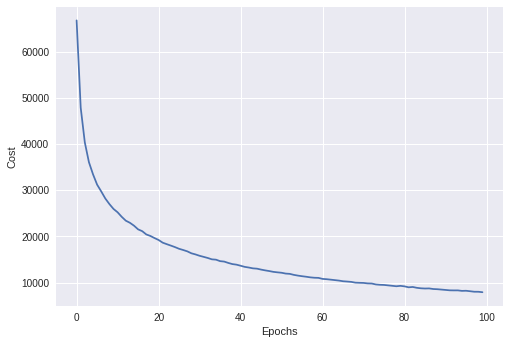

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

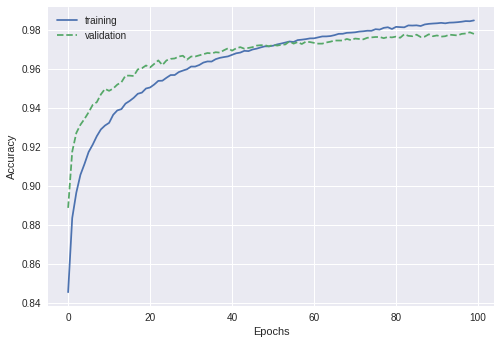

In [0]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [0]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.16%


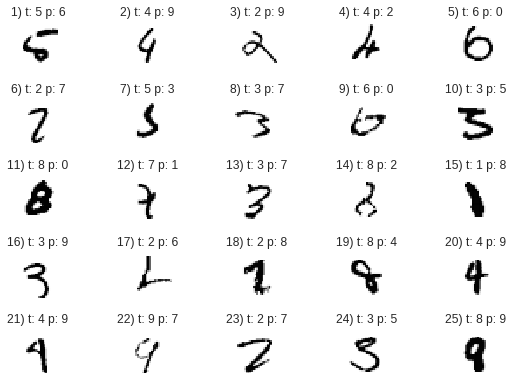

In [25]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()